# Klassifikation Land/Wasser (NDWI)

#### Jugend Forscht - Projekt: "KI-unterstützte Fernerkundung - ein Verfahren hoher Genauigkeit?"
##### Jasper Eggert, Januar 2023

##### Import wichtiger Bibliotheken und Definition der verwendeten Funktionen:

In [2]:
#Import der nötigen Bibliotheken
#SNAPPY-Schnittstelle
import sys
sys.path.append('C:\\Users\\jaspe\\anaconda3\\envs\\Snappy_JuFo\\Lib')
from snappy import ProductIO
from snappy import HashMap
from snappy import GPF

#matplotlib zur Erstellung von Visualisierungen
import matplotlib.pyplot as plot

#NumPy als Darstellungs-Backend für pixelweise Verarbeitung
import numpy as np


#scikit-image zur Manipulation der matplotlib-Darstellungen
import skimage.exposure as exposure

root_folder_path = 'D:/OneDrive - oegym.de/2021_2022/SEM11/'


import time #Time für Messungen der Ausführungszeiten
import random #Random für die zufällige Generierung der Klassifikations-Seeds

onedrive_SNAP_WS = r'D:\OneDrive - oegym.de\2022_2023\Jugend Forscht\SNAP Workspace'

#Definition einer Funktion zum Darstellen der Bilder:
def plot_image(title, bandName, product, cmap, quad_size):
    width = product.getSceneRasterWidth()
    height = product.getSceneRasterHeight()
    band_data = np.zeros(width * height)
    data = product.getBand(bandName).readPixels(0, 0, width, height, band_data)
    band_data.shape = height, width

    val1,val2 = np.percentile(band_data, (2.5,97.5))
    band_data_new = exposure.rescale_intensity(band_data, in_range=(val1,val2))

    w_fig = quad_size
    h_fig = quad_size
    plot.figure(figsize=(w_fig, h_fig))
    plot.imshow(band_data_new, cmap=cmap)
    plot.title(title)

#Definition einer Funktion zur NDVI-Berechnung
def calc_ndvi(product_in, redSourceBand, nirSourceBand, redFactor, nirFactor):
    params = HashMap()
    params.put('redSourceBand', redSourceBand)
    params.put('nirSourceBand', nirSourceBand)
    params.put('redFactor', redFactor)
    params.put('nirFactor', nirFactor)

    return GPF.createProduct('NdviOp', params, product_in)

#Funktion zum Resampling der Satellitenbilder
def S2Resampling (product_in, resolution):
    params = HashMap()
    params.put('resolution', resolution)
    params.put('upsampling', 'Bilinear')
    params.put('downsampling', 'Mean')
    params.put('flagDownsampling', 'First')
    params.put('resampleOnPyramidLevels', True)

    return GPF.createProduct('S2Resampling', params, product_in)

def kmeans_class(product_in, numIterations, numClusters):
    params = HashMap()
    params.put('clusterCount', numClusters)
    params.put('iterationCount', numIterations)
    params.put('randomSeed', random.randint(1,10000))

    return GPF.createProduct('KMeansClusterAnalysis', params, product_in)

##### Einlesen der Quelldaten (L1C):

In [2]:
%%time
full_L1C = ProductIO.readProduct (onedrive_SNAP_WS + r'\Satellitendaten\Source\S2A_MSIL1C_20220812T103031_N0400_R108_T32UME_20220812T155113.zip') # full: Präfix für vollständiges Quellprodukt mit allen Bändern

Wall time: 5.82 s


##### Laden des aufbereiteten Produkts (Rayleigh-Korrektur + Resampling):
(siehe k-means-Klassifikation Land/Wasser)

In [6]:
%%time
full_L1C_Res10 = ProductIO.readProduct(onedrive_SNAP_WS + r'\Satellitendaten\Full_L1C_Res10.dim')

Wall time: 1.42 s


Berechnung des NDVI des L1C-Produkts mittels vorher definierter Funktion und Speichern dieses Produkts:

In [7]:
L1C_NDVI = calc_ndvi(full_L1C_Res10, 'B4', 'B8', '1.0', '1.0')
ProductIO.writeProduct(L1C_NDVI, onedrive_SNAP_WS + r'\Satellitendaten\NDVI\L1C_NDVI.tif', 'GeoTIFF')

Klassifikationen mit K-Means-Operator des SNAP-GPF (Graph Processing Framework):

In [5]:
%%timeit
L1C_NDVI_kmeans_2_200 = kmeans_class(L1C_NDVI, 200, 2)

848 µs ± 328 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [6]:
%%timeit
L1C_NDVI_kmeans_2_300 = kmeans_class(L1C_NDVI, 300, 2)

699 µs ± 126 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [7]:
%%timeit
L1C_NDVI_kmeans_3_200 = kmeans_class(L1C_NDVI, 200, 3)

666 µs ± 107 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [8]:
%%timeit
L1C_NDVI_kmeans_3_300 = kmeans_class(L1C_NDVI, 300, 3)

757 µs ± 157 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


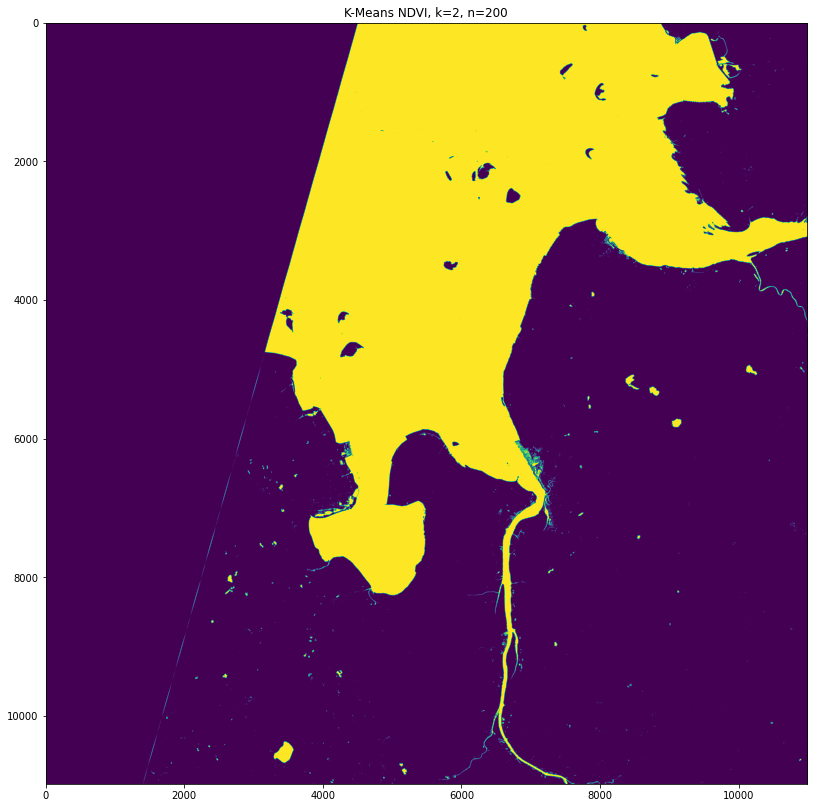

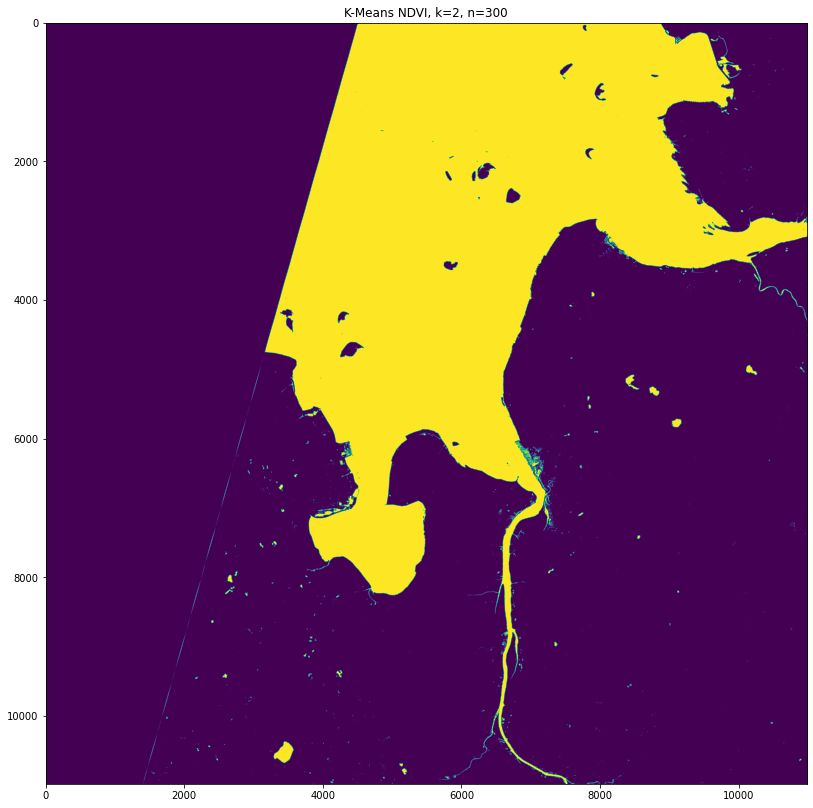

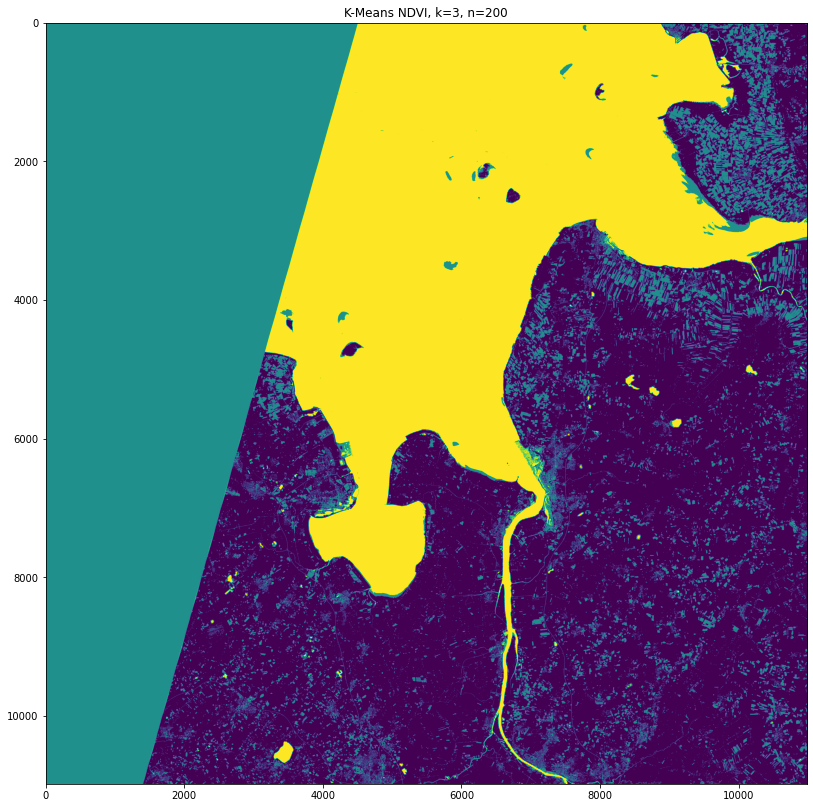

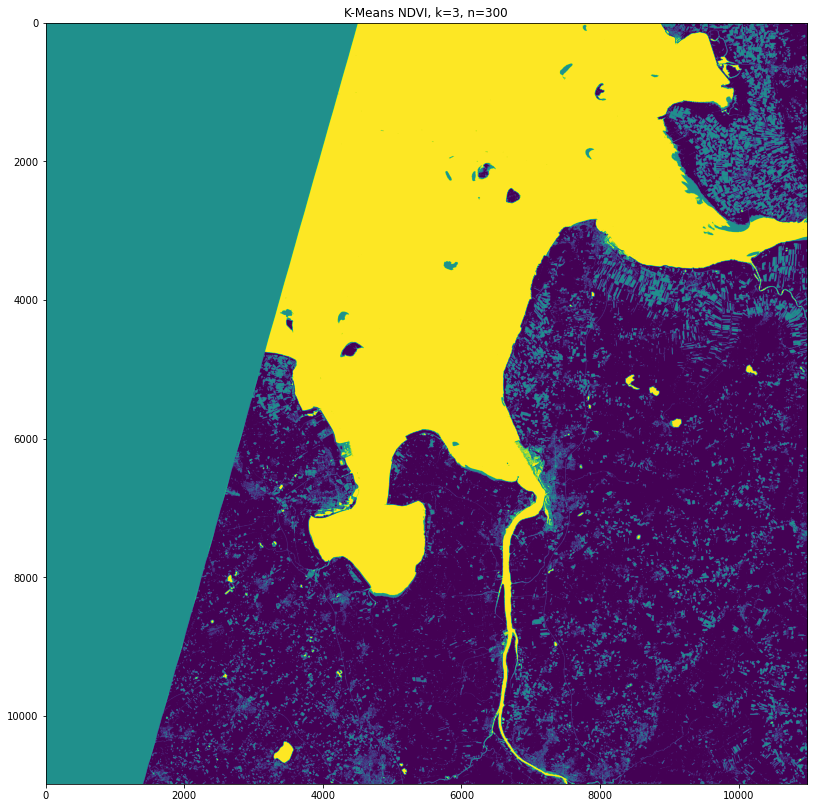

In [12]:
L1C_NDVI_kmeans_2_200 = kmeans_class(L1C_NDVI, 200, 2)
L1C_NDVI_kmeans_2_300 = kmeans_class(L1C_NDVI, 300, 2)
L1C_NDVI_kmeans_3_200 = kmeans_class(L1C_NDVI, 200, 3)
L1C_NDVI_kmeans_3_300 = kmeans_class(L1C_NDVI, 300, 3)

plot_image('K-Means NDVI, k=2, n=200', 'class_indices', L1C_NDVI_kmeans_2_200, plot.cm.viridis, 14)
plot_image('K-Means NDVI, k=2, n=300', 'class_indices', L1C_NDVI_kmeans_2_300, plot.cm.viridis, 14)
plot_image('K-Means NDVI, k=3, n=200', 'class_indices', L1C_NDVI_kmeans_3_200, plot.cm.viridis, 14)
plot_image('K-Means NDVI, k=3, n=300', 'class_indices', L1C_NDVI_kmeans_3_300, plot.cm.viridis, 14)

ProductIO.writeProduct(L1C_NDVI_kmeans_2_200, onedrive_SNAP_WS + r'\Satellitendaten\NDVI\L1C_NDVI_KMeans_2_200', 'GeoTIFF')
ProductIO.writeProduct(L1C_NDVI_kmeans_2_300, onedrive_SNAP_WS + r'\Satellitendaten\NDVI\L1C_NDVI_KMeans_2_300', 'GeoTIFF')
ProductIO.writeProduct(L1C_NDVI_kmeans_3_200, onedrive_SNAP_WS + r'\Satellitendaten\NDVI\L1C_NDVI_KMeans_3_200', 'GeoTIFF')
ProductIO.(L1C_NDVI_kmeans_3_300, onedrive_SNAP_WS + r'\Satellitendaten\NDVI\L1C_NDVI_KMeans_3_300', 'GeoTIFF')

Klassifikation mit $k=5; n=300$ (da Implementation der Elbow-Methode nicht realisierbar)

Wall time: 2min 58s


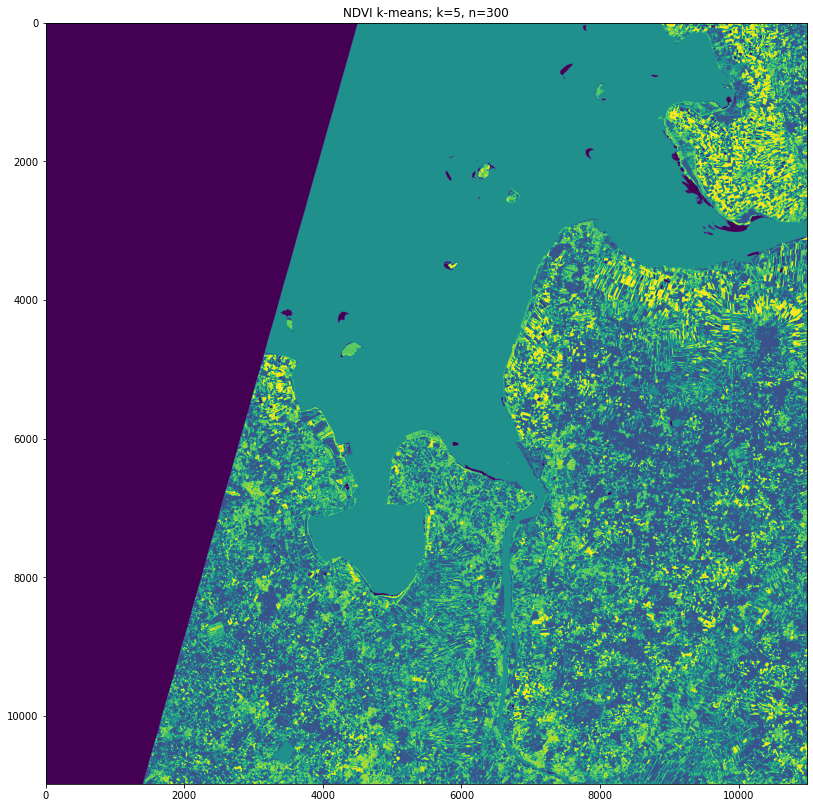

In [8]:
%%time
L1C_NDVI_kmeans_5_300 = kmeans_class(L1C_NDVI, 300, 5)
plot_image('NDVI k-means; k=5, n=300', 'class_indices', L1C_NDVI_kmeans_5_300, plot.cm.viridis, 14)
ProductIO.writeProduct(L1C_NDVI_kmeans_5_300, onedrive_SNAP_WS + r'\Satellitendaten\NDVI\L1C_NDVI_kmeans_5_300', 'GeoTIFF')